In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
  !cp -r '/content/drive/My Drive/mycode_dataset' '/subject101.dat'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss

In [4]:


df1=pd.read_table(r'/content/drive/My Drive/mycode_dataset' '/subject101.dat')
print(df1)

       8.38 0 104 30 2.37223 8.60074 3.51048 2.43954 8.76165 3.35465 -0.0922174 0.0568115 -0.0158445 14.6806 -69.2128 -5.58905 1 0 0 0 31.8125 0.23808 9.80003 -1.68896 0.265304 9.81549 -1.41344 -0.00506495 -0.00678097 -0.00566295 0.47196 -51.0499 43.2903 1 0 0 0 30.3125 9.65918 -1.65569 -0.0997967 9.64689 -1.55576 0.310404 0.00830026 0.00925038 -0.0175803 -61.1888 -38.9599 -58.1438 1 0 0 0
0       8.39 0 NaN 30 2.18837 8.5656 3.66179 2.39494 8...                                                                                                                                                                                                                                                                                                                                               
1       8.4 0 NaN 30 2.37357 8.60107 3.54898 2.30514 8...                                                                                                                                                             

In [5]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [6]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root='/content/drive/My Drive/mycode_dataset' '/subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,102):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

In [7]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,hand_3D_magnetometer_x,hand_3D_magnetometer_y,hand_3D_magnetometer_z,hand_4D_orientation_x,hand_4D_orientation_y,hand_4D_orientation_z,hand_4D_orientation_w,chest_temperature,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,chest_3D_acceleration_16_z,chest_3D_acceleration_6_x,chest_3D_acceleration_6_y,chest_3D_acceleration_6_z,chest_3D_gyroscope_x,chest_3D_gyroscope_y,chest_3D_gyroscope_z,chest_3D_magnetometer_x,chest_3D_magnetometer_y,chest_3D_magnetometer_z,chest_4D_orientation_x,chest_4D_orientation_y,chest_4D_orientation_z,chest_4D_orientation_w,ankle_temperature,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,1.0,0.0,0.0,0.0,31.8125,0.238080,9.80003,-1.68896,0.265304,9.81549,-1.41344,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,1.0,0.0,0.0,0.0,30.3125,9.65918,-1.655690,-0.099797,9.64689,-1.555760,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,-0.024413,0.047758,0.006474,14.8991,-69.2224,-5.82311,1.0,0.0,0.0,0.0,31.8125,0.319530,9.61282,-1.49328,0.234939,9.78539,-1.42846,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,1.0,0.0,0.0,0.0,30.3125,9.69370,-1.579020,-0.215687,9.61670,-1.616300,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,1.0,0.0,0.0,0.0,31.8125,0.235593,9.72421,-1.76621,0.173850,9.72528,-1.51894,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,1.0,0.0,0.0,0.0,30.3125,9.58944,-1.732760,0.092914,9.63173,-1.586050,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,1.0,0.0,0.0,0.0,31.8125,0.388697,9.53572,-1.72410,0.157969,9.64994,-1.57952,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,1.0,0.0,0.0,0.0,30.3125,9.58814,-1.770400,0.054545,9.63197,-1.631350,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,1.0,0.0,0.0,0.0,31.8125,0.315800,9.49908,-1.60914,0.233506,9.57411,-1.44418,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,1.0,0.0,0.0,0.0,30.3125,9.69771,-1.656250,-0.060809,9.64699,-1.646470,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376412,3772.50,0,NaN,30.5,2.02477,7.29553,5.74194,2.06573,6.57692,5.92695,1.516160,-0.044713,-0.085853,18.8018,-48.7508,-32.95910,1.0,0.0,0.0,0.0,34.0625,-0.414842,9.65041,-1.85519,-0.382686,9.71142,-1.50051,0.010358,0.001925,0.008888,12.621100,-39.1506,29.6394,1.0,0.0,0.0,0.0,33.3125,9.89247,-0.404788,-0.027988,9.82743,-0.315490,0.290320,0.048745,-0.008034,0.018600,-58.8381,-36.2397,-11.0980,1.0,0.0,0.0,0.0,101
376413,3772.51,0,NaN,30.5,2.10836,7.86504,5.85674,2.08754,7.42244,5.87977,1.542230,-0.023898,-0.

In [8]:
def fix_data(data):
    select = [4,5,7,12,13,24]
    #data = data.drop(data[data['activity_id']==0].index)
    data=data[data['activity_id'].isin(select)]
    data=data[['time_stamp','activity_id','ankle_3D_acceleration_6_x','ankle_3D_acceleration_6_y','ankle_3D_acceleration_6_z','ankle_3D_gyroscope_x','ankle_3D_gyroscope_y','ankle_3D_gyroscope_z','id']]
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [9]:
data

,time_stamp,activity_id,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id
154281,1551.19,12,9.80851,-1.01234,-0.600316,-0.010195,-0.010306,-0.009147,101
154282,1551.20,12,9.73352,-1.02744,-0.569598,0.000103,-0.008209,-0.006737,101
154283,1551.21,12,9.77851,-1.07282,-0.584827,-0.003771,-0.024143,0.008858,101
154284,1551.22,12,9.77858,-1.04256,-0.569789,-0.009096,0.049125,0.004017,101
154285,1551.23,12,9.77875,-1.10300,-0.524190,-0.041132,0.005700,0.014554,101
...,...,...,...,...,...,...,...,...,...
361795,3626.33,24,9.61441,1.92197,-0.517913,-0.018273,0.000864,0.018507,101
361796,3626.34,24,9.71932,1.95217,-0.579109,-0.037873,-0.022418,-0.017999,101
361797,3626.35,24,9.83979,1.89179,-0.503878,0.059283,-0.050002,0.005630,101
361798,3626.36,24,9.88503,1.84648,-0.458567,0.049326,-0.016209,0.016162,101


In [10]:
data['activity_id'].value_counts()

4     22253
5     21265
7     20265
12    15890
13    14899
24    12912
Name: activity_id, dtype: int64

In [11]:
data.describe()

,time_stamp,activity_id,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id
count,107484.000000,107484.000000,107484.000000,107484.000000,107484.000000,107484.000000,107484.000000,107484.000000,107484.0
mean,2572.195221,9.596284,11.513754,2.294388,-1.949988,0.006077,0.012055,0.027125,101.0
std,627.919178,6.270396,7.710449,10.334108,4.472462,1.449373,0.924584,2.942956,0.0
min,1551.190000,4.000000,-46.950900,-61.898600,-48.112900,-11.688700,-7.807450,-11.619400,101.0
25%,1966.707500,5.000000,8.546870,-1.650033,-3.648251,-0.772434,-0.281190,-1.950663,101.0
50%,2547.125000,7.000000,10.000200,0.693520,-2.053110,-0.140393,0.121722,-0.265763,101.0
75%,3208.852500,13.000000,15.201200,4.990543,-0.383546,0.721831,0.529137,1.071542,101.0
max,3626.370000,24.000000,61.969300,62.023800,44.231200,13.142500,6.410380,9.377020,101.0


In [12]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
#result_id = data.groupby(['id']).mean().reset_index()
#print('Number of unique ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Numbe of unique activities in the data: ',len(result_act))


Size of the data:  967356
Shape of the data:  (107484, 9)
Number of columns in the data:  9
Numbe of unique activities in the data:  6


In [13]:
def pd_fast_plot(pd,column_a,column_b,title, figsize=(10,6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, pd[column_a], color=plt.cm.Paired(size))
    a = ax.set_xticklabels(pd[column_b])
    b = ax.legend(fontsize = 20)
    c = ax.set_xticks(np.arange(len(pd)))
    d = ax.set_title(title)
    plt.show()

No handles with labels found to put in legend.


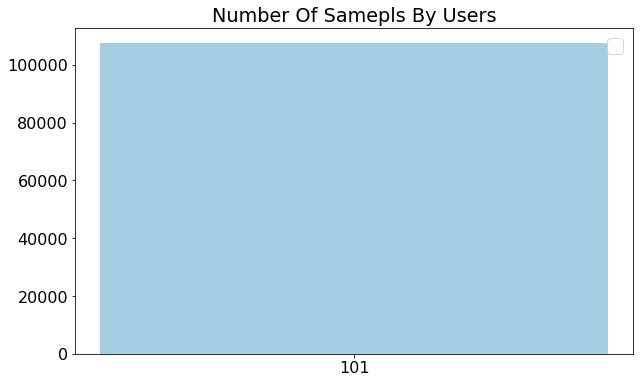

In [14]:
sampels = data.groupby(['id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['id'] = sampels['id']
sampels_to_subject['sampels'] = sampels['time_stamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
pd_fast_plot(sampels_to_subject,'sampels','id','Number Of Samepls By Users')

No handles with labels found to put in legend.


0              walking
1              running
2       Nordic_walking
3     ascending_stairs
4    descending_stairs
5         rope_jumping
Name: activity, dtype: object


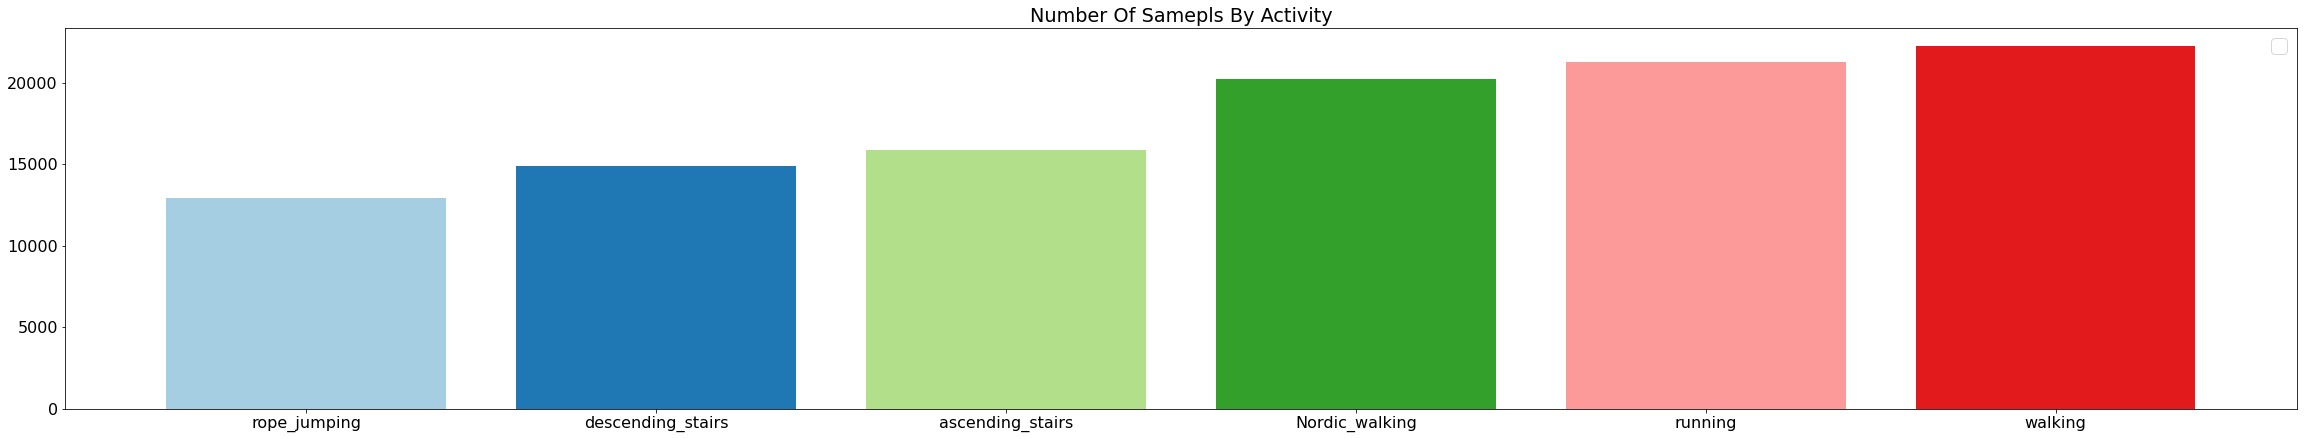

In [77]:
map_ac = load_activity_map()
sampels = data.groupby(['activity_id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['activity'] = [map_ac[x] for x in sampels['activity_id']]
sampels_to_subject['sampels'] = sampels['time_stamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
pd_fast_plot(sampels_to_subject,'sampels','activity','Number Of Samepls By Activity',figsize=(40,7))

In [16]:
features = data[['ankle_3D_acceleration_6_x','ankle_3D_acceleration_6_y','ankle_3D_acceleration_6_z','ankle_3D_gyroscope_x','ankle_3D_gyroscope_y','ankle_3D_gyroscope_z']]
label = data['activity_id']

In [17]:
features

,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z
154281,9.80851,-1.01234,-0.600316,-0.010195,-0.010306,-0.009147
154282,9.73352,-1.02744,-0.569598,0.000103,-0.008209,-0.006737
154283,9.77851,-1.07282,-0.584827,-0.003771,-0.024143,0.008858
154284,9.77858,-1.04256,-0.569789,-0.009096,0.049125,0.004017
154285,9.77875,-1.10300,-0.524190,-0.041132,0.005700,0.014554
...,...,...,...,...,...,...
361795,9.61441,1.92197,-0.517913,-0.018273,0.000864,0.018507
361796,9.71932,1.95217,-0.579109,-0.037873,-0.022418,-0.017999
361797,9.83979,1.89179,-0.503878,0.059283,-0.050002,0.005630
361798,9.88503,1.84648,-0.458567,0.049326,-0.016209,0.016162


In [18]:
label

154281    12
154282    12
154283    12
154284    12
154285    12
          ..
361795    24
361796    24
361797    24
361798    24
361799    24
Name: activity_id, Length: 107484, dtype: int64

In [52]:
x_train, x_test, y_train, y_test = train_test_split(features, label ,test_size = 0.85, shuffle=True)

In [53]:
#Dimension of train and test set
print('Train set dimension : ',x_train.shape)
print('Test set dimension : ' ,x_test.shape)

Train set dimension :  (16122, 6)
Test set dimension :  (91362, 6)


In [54]:
x_train = preprocessing.scale(x_train)
x_test = preprocessing.scale(x_test)

parameters = {'kernel':(['rbf']), 'gamma':[0.00001, 0.0001,0.001,0.1], 'C':[ 1, 10, 100, 1000]} #,{'kernel':(['poly']), 'C':[100], 'gamma':[0.0001]}]
svr = svm.SVC()
clf = GridSearchCV(svr, parameters,cv=5)
#Create a svm Classifier
#clf = svm.SVC(kernel='rbf',gamma=0.001,C=1000) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)


In [55]:
parameters

{'C': [1, 10, 100, 1000],
 'gamma': [1e-05, 0.0001, 0.001, 0.1],
 'kernel': ['rbf']}

In [56]:
clf

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1e-05, 0.0001, 0.001, 0.1],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [60]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7328429762921127


In [74]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,  average='macro'))

Precision: 0.756724289177478
Recall: 0.7297292451625421


In [75]:
confusion_matrix(y_test, y_pred)

array([[14476,   145,  2378,  1475,   400,    40],
       [  264, 15884,   129,  1480,   155,   125],
       [ 4882,   188,  9384,  2127,   472,    98],
       [  500,   278,   568, 11247,   648,   254],
       [ 1606,   317,   862,  1718,  7893,   361],
       [  242,   278,   188,  1787,   443,  8070]])

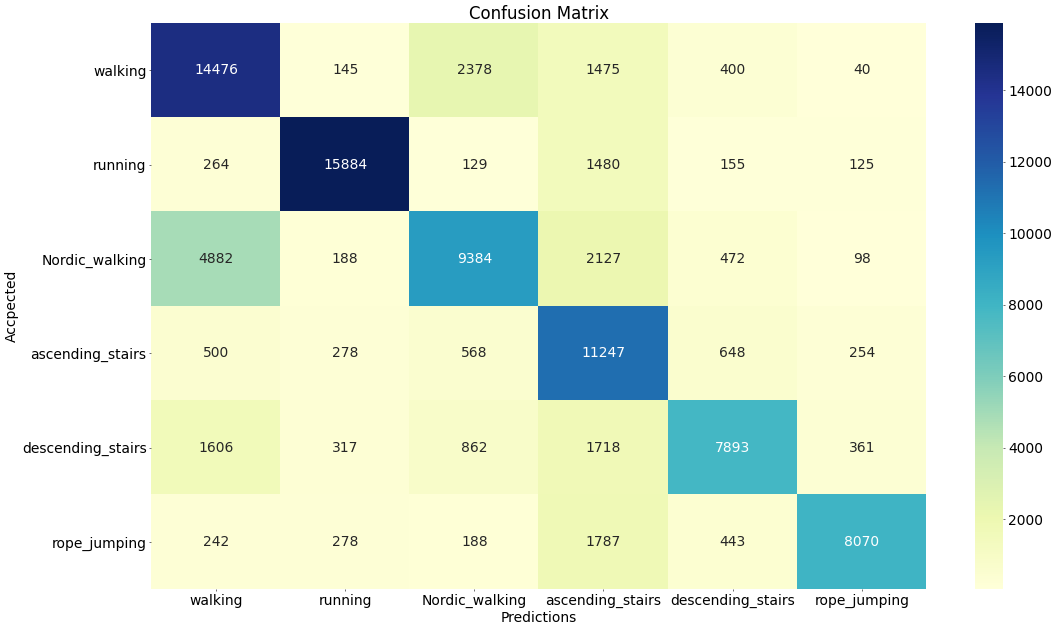

In [80]:
def quick_plot_con_matrix(y, results,labels):
    # now print confusion metrix
    con = confusion_matrix(y,results)
    a = plt.figure(figsize=(25,15), dpi=50)
    a = sns.heatmap(con, cmap='YlGnBu', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
    a = plt.rcParams.update({'font.size': 20})
    a = plt.title('Confusion Matrix')
    a = plt.xlabel('Predictions')
    a = plt.ylabel('Accpected')

#activity_map = load_activity_map()
labels = [map_ac[x] for x in sampels['activity_id']]
quick_plot_con_matrix(y_test,y_pred, labels)